In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from AutoEncoderCNN import AE_CNN
from GridSearch import GridSearch

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
torch.set_default_device(device)
torch.cuda.empty_cache()

In [3]:
class ImageFolderWithPaths(datasets.ImageFolder):
    
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [4]:
PATH = '/groups/francescavitali/eb2/NewsubSubImages4/H&E' # /groups/francescavitali/eb2/subImages_slide299/H&E

SPLIT = [55767, 6971, 6971]

tensor_transform = transforms.ToTensor()

dataset = ImageFolderWithPaths(PATH, transform = tensor_transform)

train_set, val_set, test_set = torch.utils.data.random_split(dataset,
                                                           SPLIT,# 80%, 10%, 10%
                                                           generator=torch.Generator(device=device))

test_loader = torch.utils.data.DataLoader(dataset = test_set,
                                            batch_size = 1,
                                            shuffle = True,
                                            generator=torch.Generator(device=device))

In [5]:
model = AE_CNN().to(device)

model.load_state_dict(torch.load('./models/model_gs.pth')) # loading best model state

# setting the encoder
encoder = model.encoder

In [6]:
encoder

Sequential(
  (0): Conv2d(3, 64, kernel_size=(8, 8), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(64, 32, kernel_size=(8, 8), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(32, 26, kernel_size=(8, 8), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=28314, out_features=28314, bias=True)
)

In [7]:
class NeuralNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self._feed_forward = torch.nn.Sequential(
            torch.nn.Linear(28314, 16384),
            torch.nn.ReLU(),
            torch.nn.Linear(16384, 4096),
            torch.nn.ReLU(),
            torch.nn.Linear(4096, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1),
        )
        self._sigmoid = torch.nn.Sigmoid()

        
    
    def forward(self,  x):
        output = self._feed_forward(x) 
        return self._sigmoid(output)

In [8]:
nn = NeuralNet().to(device)
nn.load_state_dict(torch.load('./ClassifierModels/class_model_gs.pth'))

<All keys matched successfully>

In [10]:
ans = []
total_samples = 0
total_correct = 0
nn.to(device)
nn.eval()
for (image, label, fname) in test_loader:
    nn.eval()
    image = image.to(device)
    label = label.to(device)
    
    with torch.no_grad():
        # feeding through nn
        encoded = encoder(image)
        not_rounded = nn._feed_forward(encoded)
        outputs = nn._sigmoid(not_rounded)
        
        # results based on sigmoid
        if outputs < 0.5: 
            outputs = 0
        else:
            outputs = 1
            
        # for calculating percentage and visualizing
        total_correct += (outputs == label).item()
        ans.append((label.item(), outputs, fname))

        
print(f'Accuracy: {total_correct/len(test_loader)*100:.2f}%')

Accuracy: 61.24%


In [20]:
ans[0]

(1,
 0,
 ('/groups/francescavitali/eb2/NewsubSubImages4/H&E/S/091/02-091_04/013_015.png',))

In [42]:
d = {} # d[patient #] = [goal, # of 1's guessed, total images] 
for i in range(len(ans)):
    patient = ans[i][2][0].split('/')[7]
    if patient in d:
        d[patient][1] += ans[i][1]
        d[patient][2] += 1
    else:
        d[patient] = [ans[i][0], ans[i][1], 1]
        

In [56]:
total_images = []
for key in sorted(list(d.keys())):
    total_images.append(d[key][2])
    print(f'{key}: {d[key]}')
print(f'{min(total_images)=} | {max(total_images)=}')

001: [0, 6, 62]
002: [0, 3, 111]
004: [0, 2, 91]
005: [0, 1, 83]
006: [0, 3, 38]
007: [0, 4, 29]
008: [0, 4, 130]
009: [0, 4, 105]
010: [0, 1, 49]
011: [0, 1, 87]
012: [0, 3, 87]
013: [0, 2, 72]
014: [0, 1, 62]
015: [0, 4, 60]
016: [0, 6, 110]
017: [0, 2, 142]
018: [0, 1, 62]
019: [0, 2, 155]
020: [0, 13, 120]
021: [0, 0, 31]
022: [0, 6, 99]
023: [0, 3, 115]
024: [0, 2, 63]
025: [0, 7, 115]
026: [0, 2, 12]
027: [0, 6, 107]
028: [0, 4, 89]
029: [0, 0, 5]
030: [0, 6, 137]
031: [0, 5, 98]
032: [0, 1, 15]
033: [0, 4, 109]
034: [0, 6, 92]
035: [0, 2, 53]
036: [0, 3, 134]
037: [0, 1, 91]
038: [0, 1, 121]
039: [0, 0, 43]
040: [0, 8, 168]
041: [0, 2, 65]
042: [0, 12, 114]
044: [0, 0, 105]
045: [0, 0, 14]
046: [0, 3, 110]
047: [0, 4, 33]
048: [0, 3, 24]
049: [0, 4, 46]
050: [0, 4, 130]
052: [0, 3, 93]
053: [0, 3, 70]
054: [0, 3, 26]
055: [0, 2, 75]
057: [0, 1, 27]
058: [1, 8, 82]
059: [1, 2, 88]
060: [1, 11, 88]
063: [1, 8, 86]
064: [1, 5, 71]
065: [1, 17, 151]
066: [1, 4, 29]
067: [1, 0, 27]
0

In [55]:
print(sum(total_images)/len(total_images))

82.98809523809524


(array([ 4., 10.,  8., 15., 18., 13.,  7.,  5.,  2.,  2.]),
 array([  5. ,  23.3,  41.6,  59.9,  78.2,  96.5, 114.8, 133.1, 151.4,
        169.7, 188. ]),
 <BarContainer object of 10 artists>)

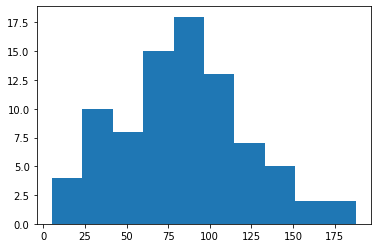

In [49]:
import matplotlib.pyplot as plt
plt.hist(total_images)

In [38]:
max_thresh = 18
for thresh in range(1,max_thresh):
    correct = 0
    for patient, val in d.items():
        guess = 0
        if val[1] > thresh:
            guess = 1
        if guess == val[0]:
            correct += 1
    print(f'Accuracy with {thresh=}: {correct/len(d.keys())*100:.2f}%')

Accuracy with thresh=1: 46.43%
Accuracy with thresh=2: 52.38%
Accuracy with thresh=3: 60.71%
Accuracy with thresh=4: 65.48%
Accuracy with thresh=5: 64.29%
Accuracy with thresh=6: 71.43%
Accuracy with thresh=7: 71.43%
Accuracy with thresh=8: 66.67%
Accuracy with thresh=9: 66.67%
Accuracy with thresh=10: 66.67%
Accuracy with thresh=11: 64.29%
Accuracy with thresh=12: 63.10%
Accuracy with thresh=13: 64.29%
Accuracy with thresh=14: 64.29%
Accuracy with thresh=15: 64.29%
Accuracy with thresh=16: 64.29%
Accuracy with thresh=17: 63.10%
